In [1]:
from BPTK_Py import Model
from BPTK_Py import sd_functions as sd
from BPTK_Py import Agent
from BPTK_Py import Model
from BPTK_Py import Event
from BPTK_Py import DataCollector
from BPTK_Py import SimultaneousScheduler
class Customer(Agent):
    def initialize(self):
        self.agent_type = "customer"
        self.state = "active"
class CustomerAcquisitionSD():
    def __init__(self,model):
        self.model = model
        
        # stocks
        self.customers = model.stock("customers")
        
        #flows
        self.customer_acquisition=model.flow("customer_acquisition")
        
        #converters
        self.acquisition_through_advertising = model.converter("acquisition_through_advertising")
        self.acquisition_through_word_of_mouth = model.converter("acquisition_through_word_of_mouth")
        self.consumers_reached_through_advertising = model.converter("consumers_reached_through_advertising")
        self.consumers_reached_through_word_of_mouth= model.converter("consumers_reached_through_word_of_mouth")
        self.market_saturation = model.converter("market_saturation")
        
        #constants
        self.initial_customers = model.constant("initial_customers") 
        self.target_market= model.constant("target_market")
        self.advertising_success = model.constant("advertising_success")
        self.consumers_reached_per_euro = model.constant("consumers_reached_per_ruro")
        self.advertising_budget = model.constant("advertising_budget")
        self.word_of_mouth_success = model.constant("word_of_mouth_success")
        self.contact_rate = model.constant("contact_rate")
        
        #equations
        self.customers.equation = self.customer_acquisition
        self.customer_acquisition.equation=self.acquisition_through_advertising+self.acquisition_through_word_of_mouth
        self.acquisition_through_advertising.equation = self.advertising_success*self.consumers_reached_through_advertising
        self.consumers_reached_through_advertising.equation = self.consumers_reached_per_euro*self.advertising_budget*(1-self.market_saturation)
        self.market_saturation.equation = self.customers/self.target_market
        self.acquisition_through_word_of_mouth.equation = self.word_of_mouth_success*self.consumers_reached_through_word_of_mouth
        self.consumers_reached_through_word_of_mouth.equation=self.contact_rate*self.customers*(1-self.market_saturation)
        
        #initialize model
        self.customers.initial_value=self.initial_customers
        self.initial_customers.equation = 0.0
        self.target_market.equation = 60000.0
        self.advertising_success.equation = 0.1
        self.consumers_reached_per_euro.equation = 1.0
        self.advertising_budget.equation = 100.0
        self.word_of_mouth_success.equation = 0.01
        self.contact_rate.equation = 1.0

class CustomerAcquisitionHybrid(Model):
    def instantiate_model(self):
        super().instantiate_model()
        # register agent factories
        self.register_agent_factory("customer", lambda agent_id,model,properties: Customer(agent_id, model,properties))
        
        # set up the sd model - keep it in its own class so we can use the SD DSL
         
        self.sd_model = CustomerAcquisitionSD(self)
      
    def configure(self,config):
        super().configure(config)
        
        ## the config sets the model properties, which we need to set the initial values of the sd model
        self.sd_model.target_market.equation = self.target_market
        self.sd_model.advertising_success.equation = self.advertising_success
        self.sd_model.consumers_reached_per_euro.equation = self.consumers_reached_per_euro
        self.sd_model.advertising_budget.equation = self.advertising_budget
        self.sd_model.word_of_mouth_success.equation = self.word_of_mouth_success
        self.sd_model.contact_rate.equation = self.contact_rate
        
        
        
    def begin_round(self, time, sim_round, step):
        # at the beginning of each round we check to see how many customers we should have according to the
        # SD model and then create the right number of agents.
        
        required_num_customers = int(self.evaluate_equation("customers",time))
        current_num_customers = self.agent_count("customer")
        agents_needed = required_num_customers-current_num_customers
        self.create_agents({"name":"customer","count":agents_needed})
        
    
customer_acquisition_hybrid=CustomerAcquisitionHybrid(1,60,dt=1,name="Customer Acquisition Hybrid",scheduler=SimultaneousScheduler(),data_collector=DataCollector())
customer_acquisition_hybrid.instantiate_model()
customer_acquisition_hybrid_config =  {
             "runspecs": {
                  "starttime": 1,
                  "stoptime":60,
                  "dt": 1.0
            },
            "properties":
            {
                 "word_of_mouth_success":
                {
                    "type":"Double",
                    "value":0.01
                },
                "advertising_success":
                {
                    "type":"Double",
                    "value":0.1
                },
                "consumers_reached_per_euro":
                {
                    "type":"Double",
                    "value":100.0
                },
                "advertising_budget":
                {
                    "type":"Double",
                    "value":100.0
                },
                "contact_rate":
                {
                    "type":"Double",
                    "value":10.0
                },
                "target_market":
                {
                    "type":"Double",
                    "value":60000.0
                }
                
            },
            "agents":
            [
                {
                    "name":"customer",
                    "count":0
                }
            ]
        }
customer_acquisition_hybrid.configure(customer_acquisition_hybrid_config)
customer_acquisition_hybrid.run()
[customer_acquisition_hybrid.statistics().get(1.0*key) for key in range(2,10)]

[{'customer': {'active': {'count': 1000}}},
 {'customer': {'active': {'count': 2081}}},
 {'customer': {'active': {'count': 3247}}},
 {'customer': {'active': {'count': 4500}}},
 {'customer': {'active': {'count': 5842}}},
 {'customer': {'active': {'count': 7272}}},
 {'customer': {'active': {'count': 8790}}},
 {'customer': {'active': {'count': 10393}}}]

Output()

Output()

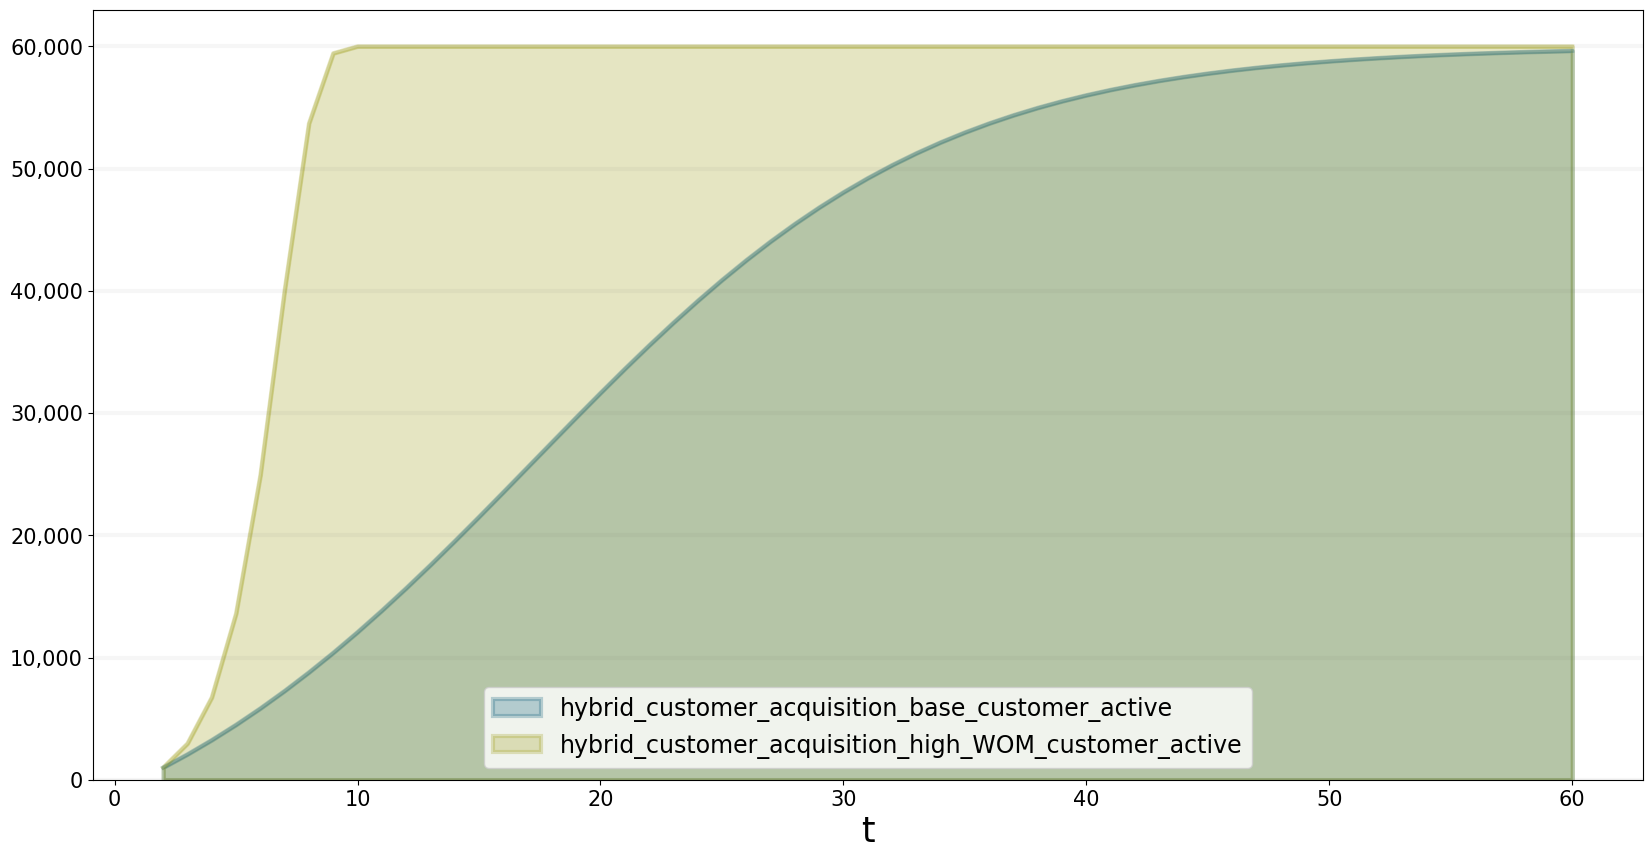

In [8]:
import BPTK_Py
bptk = BPTK_Py.bptk()
customer_acquisition_hybrid.reset()
hybrid_scenario_manager={
    "hybrid_customer_acquisition":{
        "name":"hybrid_customer_acquisition",
        "type":"abm",
        "model":customer_acquisition_hybrid,
        "scenarios":{
            "base":
           {
             "runspecs": {
                  "starttime": 1,
                  "stoptime":60,
                  "dt": 1.0
            },
            "properties":
            {
                 "word_of_mouth_success":
                {
                    "type":"Double",
                    "value":0.01
                },
                "advertising_success":
                {
                    "type":"Double",
                    "value":0.1
                },
                "consumers_reached_per_euro":
                {
                    "type":"Double",
                    "value":100.0
                },
                "advertising_budget":
                {
                    "type":"Double",
                    "value":100.0
                },
                "contact_rate":
                {
                    "type":"Double",
                    "value":10.0
                },
                "target_market":
                {
                    "type":"Double",
                    "value":60000.0
                }
                
            },
            "agents":
            [
                {
                    "name":"customer",
                    "count":0
                }
                
            ]
        },
            "high_WOM":
           {
             "runspecs": {
                  "starttime": 1,
                  "stoptime":60,
                  "dt": 1.0
            },
            "properties":
            {
                 "word_of_mouth_success":
                {
                    "type":"Double",
                    "value":0.1
                },
                "advertising_success":
                {
                    "type":"Double",
                    "value":0.1
                },
                "consumers_reached_per_euro":
                {
                    "type":"Double",
                    "value":100.0
                },
                "advertising_budget":
                {
                    "type":"Double",
                    "value":100.0
                },
                "contact_rate":
                {
                    "type":"Double",
                    "value":10.0
                },
                "target_market":
                {
                    "type":"Double",
                    "value":60000.0
                }
                
            },
            "agents":
            [
                {
                    "name":"customer",
                    "count":0
                }
                
            ]
        }
        }
    }   
}

bptk.register_scenario_manager(hybrid_scenario_manager)

bptk.plot_scenarios(
    scenario_managers=["hybrid_customer_acquisition"],
    scenarios=["base","high_WOM"],
    agents=["customer"],
    agent_states=["active"],
    series_names={
        "base_customers":"Base",
        "high_word_of_mouth_customers":"high_WOM",
    },
    progress_bar=True
)   